<a href="https://colab.research.google.com/github/JairEsc/Aproximaciones-de-Modelos-Epidemiologicos/blob/main/EBCM_NM_simulaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
import networkx as nx

In [2]:
def Funciones_dado_metodo(u,method='',params=[],densities=[],survivals=[],aristas_en_riesgo=[],vertices_infecciosos=[]):
  if method=='general' or method=='aproximado':
    psi_infection,psi_recovery=densities
    psi_survival_infection,psi_survival_recovery=survivals
    def f_to_solve_general(x):
      S_1=np.sum([np.log(psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([np.log(psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
      S_3=np.sum([np.log(psi_survival_infection(r)) for r in aristas_en_riesgo['tiempo']])
      S_4=np.sum([np.log(psi_survival_recovery(r)) for r in vertices_infecciosos['tiempo']])
      return (S_1+S_2-S_3-S_4-np.log(u))
    def f_to_solve_general_prime(x):
      S_1=np.sum([(psi_infection(x+r)/psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([(psi_recovery(x+r)/psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
      return (-S_1-S_2)
    return 0,0,0,0,f_to_solve_general,f_to_solve_general_prime
  if method=='Weibull':
    a_I,a_R,lammbda_I,lammbda_R=params
    def f_to_solve(x):
      S_1=np.sum([(x+r)**(a_I) for r in aristas_en_riesgo['tiempo']])
      S_2=np.sum([(x+r)**(a_R) for r in vertices_infecciosos['tiempo']])
      S_3=np.sum([r**a_I for r in aristas_en_riesgo['tiempo']])
      S_4=np.sum([r**a_R for r in vertices_infecciosos['tiempo']])
      return ((lammbda_I**(a_I))*(S_1-S_3)+(lammbda_R**(a_R))*(S_2-S_4)+np.log(u))
    def f_to_solve_prime(x):
      S_1=a_I*np.sum([(x+r)**(a_I-1) for r in aristas_en_riesgo['tiempo']])
      S_2=a_R*np.sum([(x+r)**(a_R-1) for r in vertices_infecciosos['tiempo']])
      return (a_I*(lammbda_I**(a_I))*S_1+a_R*(lammbda_R**(a_R))*S_2)
    return  a_I,a_R,lammbda_I,lammbda_R,f_to_solve,f_to_solve_prime
def Gillespie_Direct_Method_Non_markovian_network(N,X_I_indexes,method='',params=[],densities=[],survivals=[],G_network_initial=nx.Graph(),T=np.inf,tuto=False):
  #Recibe: method:
    #'general': Dando las densidades y supervivencias
    #'aproximado': Dando las densidades y supervivencias
    #'Weibull': Dando un vector de parámetros con $a_I,a_R,lammbda_I,lammbda_R"
  #Recibe: G_newtwork_initial la gráfica generada con Networkx
  #Recibe: X_I_indexes, un vector de indices de los nodos incicialmente infecciosos (al tiempo t=0)

  #--------------------------------------
  #Paso 0
  t=0
  X_I=len(X_I_indexes)
  X_S=N-X_I
  X_R=0
  Historia=[[0,X_S,X_I]]
  #Definir aristas_en_riesgo:
  aristas_en_riesgo={'arista':[],'tiempo':[]}
  vertices_infecciosos={'vertice':[],'tiempo':[]}
  #Llenar estos arreglos.
  #N es el número de individuos.
  for j in X_I_indexes:
    vertices_infecciosos['vertice'].append(j)
    vertices_infecciosos['tiempo'].append(0)
    for i in range(N):
      if G_network_initial.has_edge(i,j) and i not in X_I_indexes:
        aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))#Los agregamos en un orden específico.
        aristas_en_riesgo['tiempo'].append(0)
  #--------------------------------------
  if(tuto):
    print("Inicia:")
    print("Condiciones iniciales: N=",N,'X_I=',len(X_I_indexes))
    print("aristas_en_riesgo:",aristas_en_riesgo['arista'])
    print("vertices_infecciosos:",vertices_infecciosos['vertice'])
    print("Asi se ve la grafica:n")
    nx.draw(G=G_network_initial,pos=pos,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
    plt.show()
  #Paso 1
  while(X_I>0 and t<T):
    u=np.random.uniform()
    #Definir la funcion $\Phi$.
    #Depende del metodo y los valores introducidos.
    a_I,a_R,lammbda_I,lammbda_R,f_to_solve,f_to_solve_prime=Funciones_dado_metodo(u=u,method=method,params=params,densities=densities,survivals=survivals,aristas_en_riesgo=aristas_en_riesgo,vertices_infecciosos=vertices_infecciosos)
    #--------------------------------------
    #Paso 2
    tau=0.001
    if method=='aproximado':
      if(len(aristas_en_riesgo['tiempo'])+len(vertices_infecciosos['tiempo'])>=20 ):
        sum=0
        for r in aristas_en_riesgo['tiempo']:
          sum+=psi_infection(r)/psi_survival_infection(r)
        for r in vertices_infecciosos['tiempo']:
          sum+=psi_recovery(r)/psi_survival_recovery(r)
        if(sum>0):
          tau=-np.log(u)/(sum)
      else:
        tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
    else:
      tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
    #--------------------------------------
    #Paso 3-4
    #Definir las probabilidades de elección de cada canal
    if method=='Weibull':
      pi_s_teoricas=[]
      sum=0
      for j in range(len(aristas_en_riesgo['tiempo'])):
        pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
      for j in range(len(vertices_infecciosos['tiempo'])):
        pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
      pi_s=pi_s_teoricas/np.sum(pi_s_teoricas)
    else:
      pi_s=[]
      sum=0
      for i in range(len(aristas_en_riesgo['tiempo'])):
        pi_s.append(psi_infection(aristas_en_riesgo['tiempo'][i]+tau)/psi_survival_infection(aristas_en_riesgo['tiempo'][i]+tau))
        sum+=pi_s[-1]
      for i in range(len(vertices_infecciosos['tiempo'])):
        pi_s.append(psi_recovery(vertices_infecciosos['tiempo'][i]+tau)/psi_survival_recovery(vertices_infecciosos['tiempo'][i]+tau))
        sum+=pi_s[-1]
      pi_s=pi_s/sum
    #--------------------------------------
    #Paso 5
    #Decidir el canal de reacción.
    k=np.random.choice(len(pi_s),p=pi_s)
    #--------------------------------------
    #Paso 6
    #Actualizamos los tiempos desde la última reacción de todos los canales.
    #I.e. A todas las aristas en riesgo y todos los vértices infecciosos, se les actualiza $t_j+=t_j+tau$
    #Incluso para la reacción que Sí ocurrió, pues más adelanta la eliminamos.
    aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]
    vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
    if k<len(aristas_en_riesgo['tiempo']):
      #Ocurre una infección.
      reaccion='infeccion'
      X_I+=1
      X_S-=1
      arista_elegida=aristas_en_riesgo['arista'][k]#k<len(aristas)
      involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
      #Identificar al nuevo infectado-------------
      if(G_network_initial.nodes[involucrado_1]['Estado:']=='Susceptible'):
      #involucrado_1 es el nuevo infeccioso
        nuevo_infectado=involucrado_1
      else:
        if(G_network_initial.nodes[involucrado_1]['Estado:']=='Infeccioso'):
          nuevo_infectado=involucrado_2
        else:
          print("Algo malo esta ocurriendo")
      G_network_initial.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
      #-------------------------
      #Agregarlo a la lista vertices_infecciosos con tiempo 0----
      vertices_infecciosos['vertice'].append(nuevo_infectado)
      vertices_infecciosos['tiempo'].append(0)
      #-------------------------
      #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
      for nei in G_network_initial.neighbors(nuevo_infectado):
        if(G_network_initial.nodes[nei]['Estado:']=='Susceptible'):
          aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
          aristas_en_riesgo['tiempo'].append(0)
        else:
          if(G_network_initial.nodes[nei]['Estado:']=='Infeccioso'):#Arista Infeccioso-Infeccioso, la quitamos.
            index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
            aristas_en_riesgo['arista'].pop(index)
            aristas_en_riesgo['tiempo'].pop(index)
      nuevo_involucrado=nuevo_infectado
      #-------------------------
    else:
      #Ocurre una recuperación.
      reaccion='recuperacion'
      X_I-=1
      X_R+=1
      indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])#k>=len(aristas). I.e. Es vértice
      nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
      #Actualiza el estado a Recuperado.
      G_network_initial.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
      #-----------------------------
      #Elimina de la lista vertices_infecciosos al nuevo recuperado.
      vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
      vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
      #-----------------------------
      #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
      aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
      count=-1
      for l in range(len(aristas_en_riesgo_copia)):
        edge=aristas_en_riesgo_copia[l]
        if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
          count+=1
          aristas_en_riesgo['arista'].pop(l-count)
          aristas_en_riesgo['tiempo'].pop(l-count)
      nuevo_involucrado=nuevo_recuperado
    t+=tau #Actualiza el tiempo $t=t+\tau$.
    Historia.append([t,X_S,X_I])#Focus
  #Fin del While()
  return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

In [10]:
#Generar gráfica Ley de Potencias truncada.
import time
start_time_00=time.time()
N=10**3
I_0=int(0.1*N)
import scipy.stats
s=0
for k in range(3,61):
    s+=k**(-2.5)
s=s**(-1)
deg_sum=1
while(deg_sum==1):
  grados=np.random.choice(np.arange(3,61),size=N,p=[s*k**(-2.5) for k in range(3,61)])
  deg_sum=np.sum(grados)%2
G=nx.configuration_model(grados)
G = nx.Graph(G)#Remover multi-aristas
G.remove_edges_from(nx.selfloop_edges(G))#Remover bucles
pos=nx.spring_layout(G,seed=2,k=3)
X_I_indexes=np.random.choice(N,size=I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

3.141592653589793

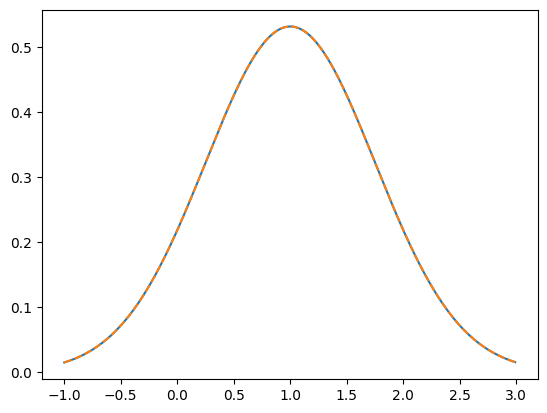

In [16]:
x=np.arange(-1,3,0.01)
sigma=0.75
mu=1
plt.plot(x,scipy.stats.norm.pdf(x,loc=1,scale=0.75))


In [17]:
#densidades y supervivencias
#normal----------------------------------
mu=1
sigma=0.75
beta=0.75
def psi_survival_infection(x):
    return np.exp(-beta*x)
def psi_survival_recovery(x):
    return 1-scipy.stats.norm.cdf(x,loc=1,scale=0.75)
def psi_infection(x):
    return beta*np.exp(-beta*x)
def psi_recovery(x):
    return scipy.stats.norm.pdf(x,loc=mu,scale=sigma)
#constante----------------------------------
#exp----------------------------------

In [8]:
np.sum([s*k**(-2.5) for k in range(3,61)])

0.9999999999999998

--- 0.11415767669677734 Segundos para crear la gráfica ---
Empieza


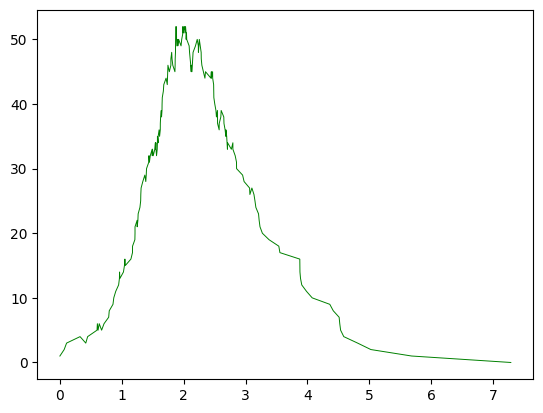

In [4]:
import time
start_time = time.time()
np.random.seed(0)
N=10**2
n=int(N*0.1)
I_0=int(0.01*N)
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.configuration_model(k_dist)
G = nx.Graph(G)#Remover multi-aristas
G.remove_edges_from(nx.selfloop_edges(G))#Remover bucles
pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
X_I_indexes=np.random.choice(N,size=I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
a_I=1.5
a_R=1.2
import math
beta=7.5
gamma=1
lammbda_I=((beta/N)*math.gamma(1+1/a_I))
lammbda_R=(gamma*math.gamma(1+1/a_R))
def psi_survival_infection(x):
    return np.exp(-(lammbda_I*x)**(a_I))
def psi_survival_recovery(x):
    return np.exp(-(lammbda_R*x)**(a_R))
def psi_infection(x):
    return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
def psi_recovery(x):
    return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
times_general=[]
times_general_approx=[]
times_weibull=[]
times_markovian=[]
matriz_trayectorias=[['MG']]
picos={"gen":[],"genApprox":[],"weib":[],"mark":[]}
for k in range(1):
    #------------------------------------ General
    iter_time = time.time()
    H=[]
    while(len(H)<100):
      G_copy=G.copy()
      X_I_indexes_copy=X_I_indexes.copy()
      H=Gillespie_Direct_Method_Non_markovian_network(N=N,X_I_indexes=X_I_indexes_copy,method='general',params=[],densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],G_network_initial=G_copy,T=14)
    if(k==0):
        plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.7,label='General (MG)')
    else:
        plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.7)
    i=np.argmax(H['I(t)'])
    picos['gen'].append([H['time'][i],H['I(t)'][i]])
    times_general.append((time.time() - iter_time))
    matriz_trayectorias.append(H['time'])
    matriz_trayectorias.append(H['I(t)'])
    matriz_trayectorias.append(['MG-T'])